# GANs Implementation for Dummy Difficulty Levels

## 1. Scenarios and Data
The data was generated from ChatGpt. Assuming the data were generated under the scenario: 2 men played a serious game in arm injury in a recovering period. The game difficulty levels are from 1, 1+, 2, 2+, 3, 3+, 4, 4+, 5. (The advanced level with + sign are indicated as an additional 0.5 value.) 5 rounds will be 1 session. There were 80 sessions in total (400 rounds). Also, assume the 2 players' heights are 173cm and 175cm, weights are 60kg and 58kg.

In [1]:
# import all the libraries
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import random

In [2]:
#import the dataframe
train = pd.read_excel(r'C:\Users\16468\Desktop\new paper\DUMMY.xlsx',header=None)
train = pd.DataFrame(train.values.reshape(80, 5), columns=['round_1', 'round_2', 'round_3','round_4','round_5'])

In [3]:
# check the data
train

,round_1,round_2,round_3,round_4,round_5
0,2.0,3.5,4.0,3.0,3.0
1,2.0,3.5,2.5,1.0,3.5
2,3.0,1.5,2.5,2.5,5.0
3,5.0,4.5,2.5,3.0,5.0
4,3.5,4.0,3.0,4.0,2.5
...,...,...,...,...,...
75,3.0,2.5,5.0,5.0,3.0
76,3.5,3.0,4.5,3.0,5.0
77,2.5,4.0,3.0,5.0,5.0
78,1.5,3.0,1.0,5.0,4.0


In [4]:
train.describe()

,round_1,round_2,round_3,round_4,round_5
count,80.000000,80.000000,80.000000,80.000000,80.000000
mean,3.325000,3.187500,3.481250,3.425000,3.412500
std,1.193601,1.212736,1.362806,1.217229,1.274817
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.375000,2.375000,2.500000,2.500000
50%,3.500000,3.000000,3.750000,3.500000,3.500000
75%,4.500000,4.000000,5.000000,4.500000,4.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000


The average data of each round is listed as 3.33, 3.19, 3.48, 3.43, 3.41. We are going to plot the data to see the general trend of difficulty levels for the 5 rounds. 

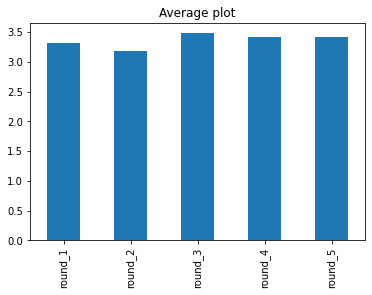

In [5]:
# plot the average
avgs = train.mean()
plot = avgs.plot(kind='bar',title="Average plot")

Ramdomly selected 5 session to plot the trend of each session.

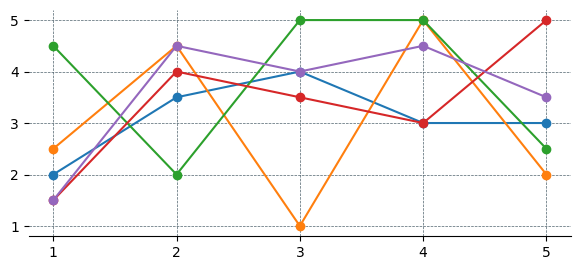

In [6]:
# plot the 5 sessions on the same plot
fig, ax = plt.subplots(figsize = (7,3), dpi = 100)

Y_1 = train.iloc[0,:]
Y_2 = train.iloc[9,:]
Y_3 = train.iloc[18,:]
Y_4 = train.iloc[20,:]
Y_5 = train.iloc[35,:]
X_ = [1,2,3,4,5]
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Remove spines and add gridlines
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.grid(ls = "--", lw = 0.5, color = "#4E616C")

# Plot
ax.plot(X_, Y_1, marker = "o")
ax.plot(X_, Y_2, marker = "o")
ax.plot(X_, Y_3, marker = "o")
ax.plot(X_, Y_4, marker = "o")
ax.plot(X_, Y_5, marker = "o")

## 2. GANs Generator Set-up

As the data of each session got 5 difficulty levels, therefore, the generator should have 5 elements as output. Now we would like to set the input of the generator includes 4 elements, which are height, weight, injury level and gender.

In [7]:
# Discriminator and Generator submodels
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 250),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(250, 125),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(125, 25),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(25, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output   
    
discriminator = Discriminator()

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 25),
            nn.ReLU(),
            nn.Linear(25, 50),
            nn.ReLU(),
            nn.Linear(50, 5),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

## 3. Data Preparation and Model Training

While training the model, the training data shoule be loaded in the stand-by status as a tensor. The label of the real data (training data) will be labeled as 0 for the discriminator step training. 

In [8]:
# Create the training tensor
train_data = torch.tensor(train.iloc[:,:].values).to(torch.float32)
# Create the zero labels for the real data
train_labels = torch.zeros(80)
train_set = [(train_data[i], train_labels[i]) for i in range(80)]

In [9]:
# set the training batch size as 10
batch_size = 5
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# tuning the parameters of the neural networks
lr = 0.001
num_epochs = 500
loss_function = nn.BCEWithLogitsLoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

#### It is important to determine the NOISES.
As we would like to generate the same pattern of future 5 rounds for the people with the similar situation, including the information of height, weight, gender as well as the injury status, the "noises" should be set as the specific range of data. Here, we are going to create some "noises" with height in range 1.70-1.75m, weight in range 5.5-6.5 (*10kg), injury status in level 2 and 3, gender only for male, indicate as 1.

The fake data will start with the "noises" and the data will be trained for those players with "noises" in that range

In [10]:
a=[[1.73,5.6,2,1],[1.70,6.1,3,1],[1.72,5.5,2,1],[1.72,5.8,2,1],[1.72,5.6,2,1],
   [1.75,5.8,3,1],[1.71,6.2,2,1],[1.70,6.2,2,1],[1.71,6.3,3,1],[1.75,6.3,3,1],
   [1.70,5.5,2,1],[1.72,6.3,3,1],[1.72,6.5,3,1],[1.73,6.1,2,1],[1.72,6.2,2,1],
   [1.72,5.6,3,1],[1.73,6.2,2,1],[1.71,5.6,2,1],[1.70,5.9,3,1],[1.72,5.9,2,1],
   [1.74,5.9,2,1],[1.74,6.5,3,1],[1.75,5.7,3,1],[1.73,6.3,2,1],[1.74,5.9,3,1],
   [1.73,6.5,3,1],[1.75,5.9,2,1],[1.70,6.3,2,1],[1.71,5.6,3,1],[1.73,6.1,2,1]]

In [11]:
ran=random.sample(a, 5)

In [12]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        
        # THE NOISES
        latent_space_samples = torch.tensor(ran).to(torch.float32)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.tensor(ran).to(torch.float32)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        #if epoch % 10 == 0 and n == batch_size-1:
    print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
    print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6286145448684692
Epoch: 0 Loss G.: 0.5055977702140808
Epoch: 1 Loss D.: 0.5919787287712097
Epoch: 1 Loss G.: 0.5610109567642212
Epoch: 2 Loss D.: 0.5941462516784668
Epoch: 2 Loss G.: 0.6201052069664001
Epoch: 3 Loss D.: 0.5082967877388
Epoch: 3 Loss G.: 0.684902548789978
Epoch: 4 Loss D.: 0.5038284063339233
Epoch: 4 Loss G.: 0.6920356750488281
Epoch: 5 Loss D.: 0.5034803152084351
Epoch: 5 Loss G.: 0.6926203370094299
Epoch: 6 Loss D.: 0.5033649206161499
Epoch: 6 Loss G.: 0.6928400993347168
Epoch: 7 Loss D.: 0.503301739692688
Epoch: 7 Loss G.: 0.6929603815078735
Epoch: 8 Loss D.: 0.503412663936615
Epoch: 8 Loss G.: 0.6930292844772339
Epoch: 9 Loss D.: 0.5034304857254028
Epoch: 9 Loss G.: 0.6930573582649231
Epoch: 10 Loss D.: 0.5032427310943604
Epoch: 10 Loss G.: 0.6930727958679199
Epoch: 11 Loss D.: 0.5032776594161987
Epoch: 11 Loss G.: 0.6930915713310242
Epoch: 12 Loss D.: 0.5032287836074829
Epoch: 12 Loss G.: 0.693101704120636
Epoch: 13 Loss D.: 0.5032232999801636
E

Epoch: 109 Loss D.: 0.5032048225402832
Epoch: 109 Loss G.: 0.6931468844413757
Epoch: 110 Loss D.: 0.5032046437263489
Epoch: 110 Loss G.: 0.6931468844413757
Epoch: 111 Loss D.: 0.5032047629356384
Epoch: 111 Loss G.: 0.6931468844413757
Epoch: 112 Loss D.: 0.5032045841217041
Epoch: 112 Loss G.: 0.6931468844413757
Epoch: 113 Loss D.: 0.5032045841217041
Epoch: 113 Loss G.: 0.6931468844413757
Epoch: 114 Loss D.: 0.5032045841217041
Epoch: 114 Loss G.: 0.6931468844413757
Epoch: 115 Loss D.: 0.5032045245170593
Epoch: 115 Loss G.: 0.6931468844413757
Epoch: 116 Loss D.: 0.5032045245170593
Epoch: 116 Loss G.: 0.6931468844413757
Epoch: 117 Loss D.: 0.5032045245170593
Epoch: 117 Loss G.: 0.6931468844413757
Epoch: 118 Loss D.: 0.5032045245170593
Epoch: 118 Loss G.: 0.6931469440460205
Epoch: 119 Loss D.: 0.5032045245170593
Epoch: 119 Loss G.: 0.6931469440460205
Epoch: 120 Loss D.: 0.5032045245170593
Epoch: 120 Loss G.: 0.6931469440460205
Epoch: 121 Loss D.: 0.5032047033309937
Epoch: 121 Loss G.: 0.693

Epoch: 218 Loss D.: 0.5032044649124146
Epoch: 218 Loss G.: 0.6931471824645996
Epoch: 219 Loss D.: 0.5032044649124146
Epoch: 219 Loss G.: 0.6931471824645996
Epoch: 220 Loss D.: 0.5032044649124146
Epoch: 220 Loss G.: 0.6931471824645996
Epoch: 221 Loss D.: 0.5032044649124146
Epoch: 221 Loss G.: 0.6931471824645996
Epoch: 222 Loss D.: 0.5032044649124146
Epoch: 222 Loss G.: 0.6931471824645996
Epoch: 223 Loss D.: 0.5032044649124146
Epoch: 223 Loss G.: 0.6931471824645996
Epoch: 224 Loss D.: 0.5032044649124146
Epoch: 224 Loss G.: 0.6931471824645996
Epoch: 225 Loss D.: 0.5032044649124146
Epoch: 225 Loss G.: 0.6931471824645996
Epoch: 226 Loss D.: 0.5032044649124146
Epoch: 226 Loss G.: 0.6931471824645996
Epoch: 227 Loss D.: 0.5032044649124146
Epoch: 227 Loss G.: 0.6931471824645996
Epoch: 228 Loss D.: 0.5032044649124146
Epoch: 228 Loss G.: 0.6931471824645996
Epoch: 229 Loss D.: 0.5032044649124146
Epoch: 229 Loss G.: 0.6931471824645996
Epoch: 230 Loss D.: 0.5032044649124146
Epoch: 230 Loss G.: 0.693

Epoch: 325 Loss D.: 0.5032044649124146
Epoch: 325 Loss G.: 0.6931471824645996
Epoch: 326 Loss D.: 0.5032044649124146
Epoch: 326 Loss G.: 0.6931471824645996
Epoch: 327 Loss D.: 0.5032044649124146
Epoch: 327 Loss G.: 0.6931471824645996
Epoch: 328 Loss D.: 0.5032044649124146
Epoch: 328 Loss G.: 0.6931471824645996
Epoch: 329 Loss D.: 0.5032044649124146
Epoch: 329 Loss G.: 0.6931471824645996
Epoch: 330 Loss D.: 0.5032044649124146
Epoch: 330 Loss G.: 0.6931471824645996
Epoch: 331 Loss D.: 0.5032044649124146
Epoch: 331 Loss G.: 0.6931471824645996
Epoch: 332 Loss D.: 0.5032044649124146
Epoch: 332 Loss G.: 0.6931471824645996
Epoch: 333 Loss D.: 0.5032044649124146
Epoch: 333 Loss G.: 0.6931471824645996
Epoch: 334 Loss D.: 0.5032044649124146
Epoch: 334 Loss G.: 0.6931471824645996
Epoch: 335 Loss D.: 0.5032044649124146
Epoch: 335 Loss G.: 0.6931471824645996
Epoch: 336 Loss D.: 0.5032044649124146
Epoch: 336 Loss G.: 0.6931471824645996
Epoch: 337 Loss D.: 0.5032044649124146
Epoch: 337 Loss G.: 0.693

Epoch: 436 Loss D.: 0.5032044649124146
Epoch: 436 Loss G.: 0.6931471824645996
Epoch: 437 Loss D.: 0.5032044649124146
Epoch: 437 Loss G.: 0.6931471824645996
Epoch: 438 Loss D.: 0.5032044649124146
Epoch: 438 Loss G.: 0.6931471824645996
Epoch: 439 Loss D.: 0.5032044649124146
Epoch: 439 Loss G.: 0.6931471824645996
Epoch: 440 Loss D.: 0.5032044649124146
Epoch: 440 Loss G.: 0.6931471824645996
Epoch: 441 Loss D.: 0.5032044649124146
Epoch: 441 Loss G.: 0.6931471824645996
Epoch: 442 Loss D.: 0.5032044649124146
Epoch: 442 Loss G.: 0.6931471824645996
Epoch: 443 Loss D.: 0.5032044649124146
Epoch: 443 Loss G.: 0.6931471824645996
Epoch: 444 Loss D.: 0.5032044649124146
Epoch: 444 Loss G.: 0.6931471824645996
Epoch: 445 Loss D.: 0.5032044649124146
Epoch: 445 Loss G.: 0.6931471824645996
Epoch: 446 Loss D.: 0.5032044649124146
Epoch: 446 Loss G.: 0.6931471824645996
Epoch: 447 Loss D.: 0.5032044649124146
Epoch: 447 Loss G.: 0.6931471824645996
Epoch: 448 Loss D.: 0.5032044649124146
Epoch: 448 Loss G.: 0.693

# 4. Result Testing

We are going to use some "noises" within the ranges for the GANs model and create some samples to see the trend of the 5 rounds of difficulty levels, and check the plot to see how different it is from the real data.

In [13]:
# input of noises and generate difficulty levels
latent_space_samples = torch.tensor([[1.75,5.6,2,1], [1.76,6.0,3,1],[1.75,6.5,2,1],[1.70,6.3,3,1],[1.74,6.2,2,1]]).to(torch.float32)
generated_samples = torch.round(generator(latent_space_samples),decimals=1)

In [14]:
# The 5 generated results.
generated_samples

tensor([[0.5000, 1.5000, 0.1000, 2.5000, 0.2000],
        [0.6000, 1.8000, 0.1000, 2.8000, 0.2000],
        [0.5000, 1.6000, 0.1000, 2.7000, 0.2000],
        [0.6000, 1.8000, 0.1000, 2.8000, 0.2000],
        [0.5000, 1.6000, 0.1000, 2.6000, 0.2000]], grad_fn=<RoundBackward1>)

In [15]:
px = pd.DataFrame(generated_samples.detach().numpy()).astype("float")

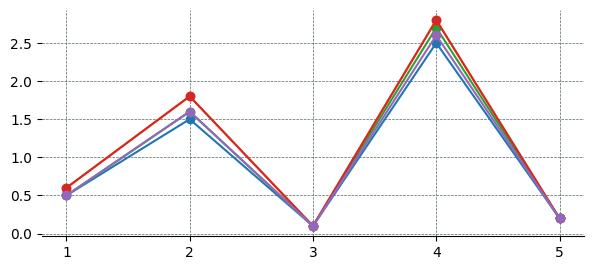

In [16]:
fig, ax = plt.subplots(figsize = (7,3), dpi = 100)

Y_1 = px.iloc[0,:]
Y_2 = px.iloc[1,:]
Y_3 = px.iloc[2,:]
Y_4 = px.iloc[3,:]
Y_5 = px.iloc[4,:]
X_ = [1,2,3,4,5]
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# --- Remove spines and add gridlines
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls = "--", lw = 0.5, color = "#4E616C")

# --- The data
ax.plot(X_, Y_1, marker = "o")
ax.plot(X_, Y_2, marker = "o")
ax.plot(X_, Y_3, marker = "o")
ax.plot(X_, Y_4, marker = "o")
ax.plot(X_, Y_5, marker = "o")

In [17]:
avgs2 = px.mean()
avgs2

0    0.54
1    1.66
2    0.10
3    2.68
4    0.20
dtype: float64

The average data of each round is listed as 2.60, 4.04, 2.10, 3.46, 4.42. We are going to plot the generated data to see the general trend of difficulty levels for the immitation 5 rounds.

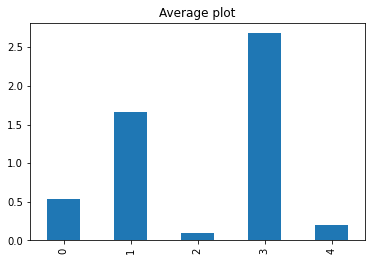

In [18]:
plot = avgs2.plot(kind='bar',title="Average plot")